# CSE574 Intro to Machine Learning Project 2
### Implement neural network and convolutional neural network for the task of classification on Fashion-MNIST clothing images
### author: Utkarsh Behre (ubehre@buffalo.edu)

#### Importing general libraries, and extracting training, validation, and testing datasets for task 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import util_mnist_reader as mnist_reader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

X_train.shape , y_train.shape, X_test.shape, y_test.shape
#print(X_train.shape, X_test.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)
print(X_train.shape, X_valid.shape, X_test.shape)

(54000, 784) (6000, 784) (10000, 784)


#### Defining all common functions to be used to train/test the model in all 3 tasks

In [7]:
# converts 1 dimensional label array into 2 dimensional array with basically 10 binary values for 10 classes for each sample
# image. Only 1 out of 10 classes will have a 1 while rest will be 0 for each sample
def transform_labels(y, m):
    Y = np.zeros((10, m))
    for i in range(m):
        Y[y[i],i] = 1;
    return Y

def plot_graph(hist):
    
    train_loss = hist["loss"]
    train_accuracy = hist["accuracy"]
    valid_loss = hist["val_loss"]
    valid_accuracy = hist["val_accuracy"]
    
    fig, graphs = plt.subplots(2,1, figsize=(8,10))
    fig.subplots_adjust(left=.2, bottom=.01, wspace=.5)
    fig.align_labels()
               
    # for each graph since we had to set labels, titles, and values repeatedly,
    # so set_graph_details() function is used to avoid code redundancy
    graph_tl = graphs[0]
    set_graph_details(graph_tl, train_loss, valid_loss, "Epochs", "Loss", "Loss vs Epochs", ("Training Loss", "Validation Loss"))
    graph_ta = graphs[1]
    set_graph_details(graph_ta, train_accuracy, valid_accuracy, "Epochs", "Accuracy (in %age)", "Accuracy vs Epochs", ("Training Accuracy", "Validation Accuracy"))              
               
# takes graph, and the details to set to the graph and sets them up
def set_graph_details(graph, values1, values2, xlbl, ylbl, title, legends):
    graph.set_xlabel(xlbl)
    graph.set_ylabel(ylbl)
    graph.set_title(title)
    graph.grid(b=None, which='major', axis='both')
    graph.plot(values1)
    graph.plot(values2)
    graph.legend(legends)

# calculates the accuracy
def calc_accuracy(y_predict, y_actual, training = False):
    if training:
        y_predict = np.argmax(y_predict, axis = 0)
        y_actual = np.argmax(y_actual, axis= 0)
    N_correct = np.sum(y_predict==y_actual)
    return N_correct *100 / y_actual.shape[0]

# This function generates below items in the report and is used to generate reports for all 3 given tasks in the project
# 1. Training & Validation loss graph
# 2. Training & Validation accuracy graph
# 4. Prints out the accuracy of the model on the given test data
# 5. Prints out the confusion matrix
# 6. Prints out the classification report
def gen_full_report(task, y_predicted, y_actual, hist):

    plot_graph(hist)
    
    y_predicted = np.argmax(y_predicted, axis = 0)
    
    print("Task ",task,": Accuracy of the model on the test set: ", calc_accuracy(y_predicted, y_actual), "%")

    conf_matrix = confusion_matrix(y_predicted, y_actual)
    print("Task ",task,": Confusion Matrix")
    print(conf_matrix)

    class_report = classification_report(y_predicted, y_actual)
    print("Task ",task,": Classification report")
    print(class_report)

### Task 1: Build a Neural Network with one hidden layer from scratch
#### Defining all the methods  to be used later

In [6]:
# Defining all the methods' definitions that will be used in later cells

def sigmoid(z):
    return 1/(1 + np.exp(-z))

# This method returns probabilities of an image for all 10 classes. The class with the highest probability 
# is the one that we use as class it predicted
def softmax(z):
    z = z - np.amax(z)
    expo = np.exp(z)
    deno = np.sum(expo, axis = 0)
    return expo/deno

# simple output predictor that runs the inputs through the neural network to get the final predictions in probabilities
def predict_output(w1, w2, w10, w20, X):
    # hypothesis function
    z1 = np.dot(w1.T, X.T) + w10  
    
    # a1 = hidden layer 
    a1 = sigmoid(z1)
    
    # a2 = output softmax layer prediction for the 10 classes after finding z2 using hypothesis function on hidden layer
    z2 = np.dot(w2.T, a1) + w20
    a2 = softmax(z2)
    return a2

# the cost function we are using
def cost(a2, Y):
    #return -np.sum(np.multiply(np.log(a2), Y) + np.multiply((1-Y), np.log(1-a2)))/a2.shape[1]
    return -np.sum(np.multiply(np.log(a2),Y))/a2.shape[1]

# deep learning method that implements single layer neural network
# batchsize = the number of samples to be used per batch for gradient descent. All the samples still go through for 1 epoch
# learning_rate = the speed at which our network trains
# epochs = number of iterations our network has to go through for training
# units = number of hidden units in the single hidden layer that we will be using
def deep_learning(X, y, X_valid, y_valid, batchsize, learning_rate, epochs=100, units=20):
    training_loss = []
    validation_loss = []
    training_accuracy = []
    validation_accuracy = []
    
    m = X.shape[0]
    m_valid = X_valid.shape[0]
    
    # initiallizing weights w1 and w2 and biases w10 and w20 with random values to find hidden layer 1 and output layer 
    w1 = np.random.randn(X.shape[1],units)
    w2 = np.random.randn(units, 10)
    w10 = np.random.randn(units,1)
    w20 = np.random.randn(10,1)
    
    # reshaping training labels so that it is 1 for respective label in 0-9 indices and 0 for others
    Y = transform_labels(y,m)
    
    # reshaping validation labels so that it is 1 for respective label in 0-9 indices and 0 for others
    Y_valid = transform_labels(y_valid,m_valid)
        
    #running gradient descent using minibatches with passed batchsize
    for epoch in range(epochs):
        
        # logic to run mini batches
        last =0
        batch = batchsize
        i = 0
        # keep running gradient descent per batchsize of samples untill all samples are done
        while last<batch:
            
            # each epoch we keep getting new X and new Y based on batchsize
            X_new = X[last:batch]
            Y_new = Y[:,last:batch]
            last = batch
            
            # make sure all samples are used and we don't exceed the index bounds
            batch = min(batch + batchsize, m)
            i = i+1
            
            # hypothesis function using bias w10
            z1 = np.dot(w1.T, X_new.T) + w10  
            
            # a1 is our hidden layer 
            a1 = sigmoid(z1)
            
            # a2 is the output softmax layer prediction for the 10 classes 
            # after finding z2 using hypothesis function on hidden layer nodes a1 using bias w20
            z2 = np.dot(w2.T, a1) + w20
            a2 = softmax(z2)
            
            # print sum of a2 for a sample to make sure we get the probabilities sum as 1 
            # and verify that our softmax function works as excpected
            # print(sum(a2.T[0])) # sum of probabilities for all classes = 1

            # Modify the weights and biases: w2, w20
            dw2 = np.dot(a1,(a2-Y_new).T)
            w2 = w2 - learning_rate * dw2
            w20 = w20 - learning_rate * dw2.sum()
        
            # modify the weights and biases: w1, w10
            diffdotw2 = np.dot((a2-Y_new).T,w2.T)
            sigdiff = (a1*(1-a1)).T
            dw1 = np.dot(X_new.T, diffdotw2 * sigdiff)
            w1 = w1 - learning_rate * dw1
            w10 = w10 - learning_rate * dw1.sum()
            
            # uncomment below to check dimensions for calculation of dw1
            # print(w2dotdiff.shape, sigdiff.shape, X.shape, dw1.shape, w1.shape) #helps understanding dimensions of matrices
    
        # checking training loss on entire training data and storing the values
        a2_train = predict_output(w1, w2, w10, w20, X)
        training_cost = cost(a2_train, Y)        
        training_loss.append(training_cost)
        t_accuracy = calc_accuracy(a2_train, Y, training=True)
        training_accuracy.append(t_accuracy)
        
        # checking validation loss on entire validation data and storing the values
        a2_valid = predict_output(w1, w2, w10, w20, X_valid)
        validation_cost = cost(a2_valid, Y_valid)
        validation_loss.append(validation_cost)
        v_accuracy = calc_accuracy(a2_valid, Y_valid, training=True)
        validation_accuracy.append(v_accuracy)
        
        # prints out costs, and accuracies for training and validation per epoch while training
        print("=======Current Epoch: ",epoch, "/", epochs, "========")
        print("Training Cost: ", training_cost, " || Validation Cost: " , validation_cost)
        print("Training Accuracy: ", t_accuracy, "% || Validation Accuracy: ", v_accuracy, "%")
    
    hist = {"loss":training_loss, "val_loss": validation_loss, "accuracy":training_accuracy, "val_accuracy":validation_accuracy}
    
    # plot training and validation loss graph
    plot_graph(hist)
    return hist, w1, w2, w10, w20

#### Training the neural network using batchsize, learning rate, epochs, hidden units as hypertuning parameters

C:\Users\Utkarsh\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


=======Current Epoch:  0 / 600 ========
Training Cost:  2.2071382330954394  || Validation Cost:  2.2095574197320773
Training Accuracy:  32.85 % || Validation Accuracy:  33.733333333333334 %
=======Current Epoch:  1 / 600 ========
Training Cost:  1.712032974413405  || Validation Cost:  1.7169837272058879
Training Accuracy:  41.48888888888889 % || Validation Accuracy:  41.75 %
=======Current Epoch:  2 / 600 ========
Training Cost:  1.4968194176783927  || Validation Cost:  1.4992926395512696
Training Accuracy:  47.43333333333333 % || Validation Accuracy:  48.416666666666664 %
=======Current Epoch:  3 / 600 ========
Training Cost:  1.3432887201994759  || Validation Cost:  1.336356606205345
Training Accuracy:  51.72037037037037 % || Validation Accuracy:  52.43333333333333 %
=======Current Epoch:  4 / 600 ========
Training Cost:  1.2586499856850173  || Validation Cost:  1.249507916401876
Training Accuracy:  54.614814814814814 % || Validation Accuracy:  54.916666666666664 %
=======Current Epo

=======Current Epoch:  43 / 600 ========
Training Cost:  0.7813978636055895  || Validation Cost:  0.8014422339984282
Training Accuracy:  70.97037037037038 % || Validation Accuracy:  71.05 %
=======Current Epoch:  44 / 600 ========
Training Cost:  0.7759409304922906  || Validation Cost:  0.8015486352333122
Training Accuracy:  71.08333333333333 % || Validation Accuracy:  70.91666666666667 %
=======Current Epoch:  45 / 600 ========
Training Cost:  0.772402936753049  || Validation Cost:  0.7926108444100559
Training Accuracy:  71.44074074074074 % || Validation Accuracy:  71.2 %
=======Current Epoch:  46 / 600 ========
Training Cost:  0.7668300822227526  || Validation Cost:  0.7851855095399519
Training Accuracy:  71.16666666666667 % || Validation Accuracy:  71.05 %
=======Current Epoch:  47 / 600 ========
Training Cost:  0.766279235050425  || Validation Cost:  0.7845298359242412
Training Accuracy:  71.57592592592593 % || Validation Accuracy:  71.2 %
=======Current Epoch:  48 / 600 ========
T

=======Current Epoch:  86 / 600 ========
Training Cost:  0.6958070577379496  || Validation Cost:  0.7127206380985722
Training Accuracy:  74.31111111111112 % || Validation Accuracy:  74.4 %
=======Current Epoch:  87 / 600 ========
Training Cost:  0.6827335514544648  || Validation Cost:  0.7029549694357918
Training Accuracy:  74.4888888888889 % || Validation Accuracy:  73.98333333333333 %
=======Current Epoch:  88 / 600 ========
Training Cost:  0.6812665763240725  || Validation Cost:  0.7002881395666932
Training Accuracy:  74.78148148148148 % || Validation Accuracy:  74.46666666666667 %
=======Current Epoch:  89 / 600 ========
Training Cost:  0.6767904926932299  || Validation Cost:  0.6967377338279945
Training Accuracy:  74.79074074074074 % || Validation Accuracy:  74.61666666666666 %
=======Current Epoch:  90 / 600 ========
Training Cost:  0.6862955059754461  || Validation Cost:  0.7101110990933198
Training Accuracy:  74.71481481481482 % || Validation Accuracy:  73.85 %
=======Current E

=======Current Epoch:  128 / 600 ========
Training Cost:  0.6352676654440798  || Validation Cost:  0.6620327276101399
Training Accuracy:  76.67407407407407 % || Validation Accuracy:  76.33333333333333 %
=======Current Epoch:  129 / 600 ========
Training Cost:  0.6492839530982514  || Validation Cost:  0.6621108844842605
Training Accuracy:  75.56851851851852 % || Validation Accuracy:  75.41666666666667 %
=======Current Epoch:  130 / 600 ========
Training Cost:  0.6447937144105389  || Validation Cost:  0.6658192145675228
Training Accuracy:  75.82222222222222 % || Validation Accuracy:  75.61666666666666 %
=======Current Epoch:  131 / 600 ========
Training Cost:  0.6447129072929061  || Validation Cost:  0.6712394195384611
Training Accuracy:  75.82777777777778 % || Validation Accuracy:  75.45 %
=======Current Epoch:  132 / 600 ========
Training Cost:  0.648907773042586  || Validation Cost:  0.672147924277139
Training Accuracy:  75.62962962962963 % || Validation Accuracy:  75.31666666666666 %

=======Current Epoch:  170 / 600 ========
Training Cost:  0.609940871416174  || Validation Cost:  0.6292014072631426
Training Accuracy:  77.78518518518518 % || Validation Accuracy:  77.28333333333333 %
=======Current Epoch:  171 / 600 ========
Training Cost:  0.6030621965432196  || Validation Cost:  0.6336113300655385
Training Accuracy:  77.88888888888889 % || Validation Accuracy:  77.46666666666667 %
=======Current Epoch:  172 / 600 ========
Training Cost:  0.6025077378487442  || Validation Cost:  0.6320380792178674
Training Accuracy:  77.8425925925926 % || Validation Accuracy:  77.35 %
=======Current Epoch:  173 / 600 ========
Training Cost:  0.6021465267952164  || Validation Cost:  0.6323227944446743
Training Accuracy:  77.88518518518518 % || Validation Accuracy:  77.26666666666667 %
=======Current Epoch:  174 / 600 ========
Training Cost:  0.6052195030906782  || Validation Cost:  0.6325229904437194
Training Accuracy:  78.28703703703704 % || Validation Accuracy:  77.48333333333333 %

=======Current Epoch:  212 / 600 ========
Training Cost:  0.5899029037458611  || Validation Cost:  0.6160317071240188
Training Accuracy:  77.88703703703703 % || Validation Accuracy:  77.56666666666666 %
=======Current Epoch:  213 / 600 ========
Training Cost:  0.5862391753615817  || Validation Cost:  0.6118966812474154
Training Accuracy:  78.54814814814814 % || Validation Accuracy:  78.7 %
=======Current Epoch:  214 / 600 ========
Training Cost:  0.5780443638783838  || Validation Cost:  0.6046552487509836
Training Accuracy:  79.07592592592593 % || Validation Accuracy:  78.81666666666666 %
=======Current Epoch:  215 / 600 ========
Training Cost:  0.5820771810218105  || Validation Cost:  0.6051202184600147
Training Accuracy:  78.54629629629629 % || Validation Accuracy:  77.96666666666667 %
=======Current Epoch:  216 / 600 ========
Training Cost:  0.5774803908246741  || Validation Cost:  0.6036115881169726
Training Accuracy:  79.09814814814816 % || Validation Accuracy:  78.41666666666667 

=======Current Epoch:  254 / 600 ========
Training Cost:  0.5754356474243708  || Validation Cost:  0.6009790365926702
Training Accuracy:  78.8425925925926 % || Validation Accuracy:  78.98333333333333 %
=======Current Epoch:  255 / 600 ========
Training Cost:  0.5655315422732761  || Validation Cost:  0.5990509268839705
Training Accuracy:  79.8462962962963 % || Validation Accuracy:  79.41666666666667 %
=======Current Epoch:  256 / 600 ========
Training Cost:  0.569098540944906  || Validation Cost:  0.5924778624919338
Training Accuracy:  79.5111111111111 % || Validation Accuracy:  79.38333333333334 %
=======Current Epoch:  257 / 600 ========
Training Cost:  0.5681866979648442  || Validation Cost:  0.5932866811122792
Training Accuracy:  79.54629629629629 % || Validation Accuracy:  79.41666666666667 %
=======Current Epoch:  258 / 600 ========
Training Cost:  0.5640070394986406  || Validation Cost:  0.5918049328786426
Training Accuracy:  79.43148148148148 % || Validation Accuracy:  79.1 %
==

=======Current Epoch:  296 / 600 ========
Training Cost:  0.5538604209442421  || Validation Cost:  0.586470336308163
Training Accuracy:  79.88888888888889 % || Validation Accuracy:  79.13333333333334 %
=======Current Epoch:  297 / 600 ========
Training Cost:  0.5489306893020216  || Validation Cost:  0.587043064541924
Training Accuracy:  80.2925925925926 % || Validation Accuracy:  79.65 %
=======Current Epoch:  298 / 600 ========
Training Cost:  0.5544376465683913  || Validation Cost:  0.5860530188028265
Training Accuracy:  80.36851851851851 % || Validation Accuracy:  79.6 %
=======Current Epoch:  299 / 600 ========
Training Cost:  0.5568813623012049  || Validation Cost:  0.5928421342023302
Training Accuracy:  80.51296296296296 % || Validation Accuracy:  79.75 %
=======Current Epoch:  300 / 600 ========
Training Cost:  0.5630175515213058  || Validation Cost:  0.5984244815017947
Training Accuracy:  79.79074074074074 % || Validation Accuracy:  79.16666666666667 %
=======Current Epoch:  30

=======Current Epoch:  338 / 600 ========
Training Cost:  0.529694159149772  || Validation Cost:  0.5641390983971375
Training Accuracy:  80.97777777777777 % || Validation Accuracy:  80.16666666666667 %
=======Current Epoch:  339 / 600 ========
Training Cost:  0.5314517777351324  || Validation Cost:  0.5678330423735034
Training Accuracy:  80.7925925925926 % || Validation Accuracy:  80.25 %
=======Current Epoch:  340 / 600 ========
Training Cost:  0.5353066773840898  || Validation Cost:  0.5725322041957427
Training Accuracy:  80.61481481481482 % || Validation Accuracy:  79.63333333333334 %
=======Current Epoch:  341 / 600 ========
Training Cost:  0.5328033672919441  || Validation Cost:  0.5673688026566696
Training Accuracy:  80.6537037037037 % || Validation Accuracy:  79.95 %
=======Current Epoch:  342 / 600 ========
Training Cost:  0.539907989715028  || Validation Cost:  0.5724124253661614
Training Accuracy:  80.46666666666667 % || Validation Accuracy:  80.03333333333333 %
=======Curren

=======Current Epoch:  380 / 600 ========
Training Cost:  0.5257768696953525  || Validation Cost:  0.5575442320464813
Training Accuracy:  81.0 % || Validation Accuracy:  80.08333333333333 %
=======Current Epoch:  381 / 600 ========
Training Cost:  0.5243885250210701  || Validation Cost:  0.5612882925613407
Training Accuracy:  81.34444444444445 % || Validation Accuracy:  80.46666666666667 %
=======Current Epoch:  382 / 600 ========
Training Cost:  0.5307859822251024  || Validation Cost:  0.563878702149764
Training Accuracy:  81.36851851851851 % || Validation Accuracy:  80.31666666666666 %
=======Current Epoch:  383 / 600 ========
Training Cost:  0.5332120216291135  || Validation Cost:  0.5601024233855407
Training Accuracy:  80.58888888888889 % || Validation Accuracy:  80.01666666666667 %
=======Current Epoch:  384 / 600 ========
Training Cost:  0.5354176148883995  || Validation Cost:  0.5689621713056386
Training Accuracy:  80.72407407407407 % || Validation Accuracy:  80.05 %
=======Curr

=======Current Epoch:  422 / 600 ========
Training Cost:  0.5199184533742514  || Validation Cost:  0.5565704317075629
Training Accuracy:  81.75 % || Validation Accuracy:  80.71666666666667 %
=======Current Epoch:  423 / 600 ========
Training Cost:  0.520070463898762  || Validation Cost:  0.5577715018159052
Training Accuracy:  81.5925925925926 % || Validation Accuracy:  80.83333333333333 %
=======Current Epoch:  424 / 600 ========
Training Cost:  0.5220076527821708  || Validation Cost:  0.5545392652149179
Training Accuracy:  81.6574074074074 % || Validation Accuracy:  80.61666666666666 %
=======Current Epoch:  425 / 600 ========
Training Cost:  0.5256676644361827  || Validation Cost:  0.5610808889645941
Training Accuracy:  81.32592592592593 % || Validation Accuracy:  80.35 %
=======Current Epoch:  426 / 600 ========
Training Cost:  0.5243708301184388  || Validation Cost:  0.5566143313678354
Training Accuracy:  81.30185185185185 % || Validation Accuracy:  81.16666666666667 %
=======Curre

=======Current Epoch:  464 / 600 ========
Training Cost:  0.5079828939061929  || Validation Cost:  0.5470140613203562
Training Accuracy:  81.73703703703704 % || Validation Accuracy:  81.26666666666667 %
=======Current Epoch:  465 / 600 ========
Training Cost:  0.5075845331131285  || Validation Cost:  0.5459980405908553
Training Accuracy:  81.8462962962963 % || Validation Accuracy:  81.08333333333333 %
=======Current Epoch:  466 / 600 ========
Training Cost:  0.5048736457365743  || Validation Cost:  0.5460081677202734
Training Accuracy:  81.87592592592593 % || Validation Accuracy:  81.38333333333334 %
=======Current Epoch:  467 / 600 ========
Training Cost:  0.5056522809551521  || Validation Cost:  0.5446288086069937
Training Accuracy:  81.99814814814815 % || Validation Accuracy:  81.06666666666666 %
=======Current Epoch:  468 / 600 ========
Training Cost:  0.5088924339753196  || Validation Cost:  0.5558186278893559
Training Accuracy:  81.87407407407407 % || Validation Accuracy:  80.783

=======Current Epoch:  506 / 600 ========
Training Cost:  0.4986097430823187  || Validation Cost:  0.5399527934814863
Training Accuracy:  82.33888888888889 % || Validation Accuracy:  81.33333333333333 %
=======Current Epoch:  507 / 600 ========
Training Cost:  0.5024842062815972  || Validation Cost:  0.5403968616208831
Training Accuracy:  81.90185185185184 % || Validation Accuracy:  81.28333333333333 %
=======Current Epoch:  508 / 600 ========
Training Cost:  0.4977446002364295  || Validation Cost:  0.5453972387829354
Training Accuracy:  82.12592592592593 % || Validation Accuracy:  81.43333333333334 %
=======Current Epoch:  509 / 600 ========
Training Cost:  0.510174195817784  || Validation Cost:  0.5565601557228157
Training Accuracy:  81.8462962962963 % || Validation Accuracy:  80.83333333333333 %
=======Current Epoch:  510 / 600 ========
Training Cost:  0.5081611273785719  || Validation Cost:  0.5492608908613594
Training Accuracy:  81.9574074074074 % || Validation Accuracy:  81.26666

=======Current Epoch:  548 / 600 ========
Training Cost:  0.5001197709357573  || Validation Cost:  0.5334555332195186
Training Accuracy:  82.06481481481481 % || Validation Accuracy:  80.9 %
=======Current Epoch:  549 / 600 ========
Training Cost:  0.4949724859251034  || Validation Cost:  0.5309843564555895
Training Accuracy:  82.03888888888889 % || Validation Accuracy:  81.26666666666667 %
=======Current Epoch:  550 / 600 ========
Training Cost:  0.49112850701947147  || Validation Cost:  0.5312296340654785
Training Accuracy:  82.54814814814814 % || Validation Accuracy:  81.65 %
=======Current Epoch:  551 / 600 ========
Training Cost:  0.4954293928022501  || Validation Cost:  0.537573730183083
Training Accuracy:  82.36666666666666 % || Validation Accuracy:  81.23333333333333 %
=======Current Epoch:  552 / 600 ========
Training Cost:  0.49249969196964055  || Validation Cost:  0.5320448404829304
Training Accuracy:  82.45925925925926 % || Validation Accuracy:  81.15 %
=======Current Epoch:

=======Current Epoch:  590 / 600 ========
Training Cost:  0.4918181589654745  || Validation Cost:  0.535554036731875
Training Accuracy:  82.39814814814815 % || Validation Accuracy:  81.05 %
=======Current Epoch:  591 / 600 ========
Training Cost:  0.49252699506378184  || Validation Cost:  0.5330465958767336
Training Accuracy:  82.13703703703703 % || Validation Accuracy:  80.91666666666667 %
=======Current Epoch:  592 / 600 ========
Training Cost:  0.4877555307328691  || Validation Cost:  0.5337037064042874
Training Accuracy:  82.6 % || Validation Accuracy:  81.25 %
=======Current Epoch:  593 / 600 ========
Training Cost:  0.48444528461813047  || Validation Cost:  0.5294464853956133
Training Accuracy:  82.71296296296296 % || Validation Accuracy:  81.26666666666667 %
=======Current Epoch:  594 / 600 ========
Training Cost:  0.4921624681523306  || Validation Cost:  0.5312850444653716
Training Accuracy:  82.6462962962963 % || Validation Accuracy:  81.56666666666666 %
=======Current Epoch: 

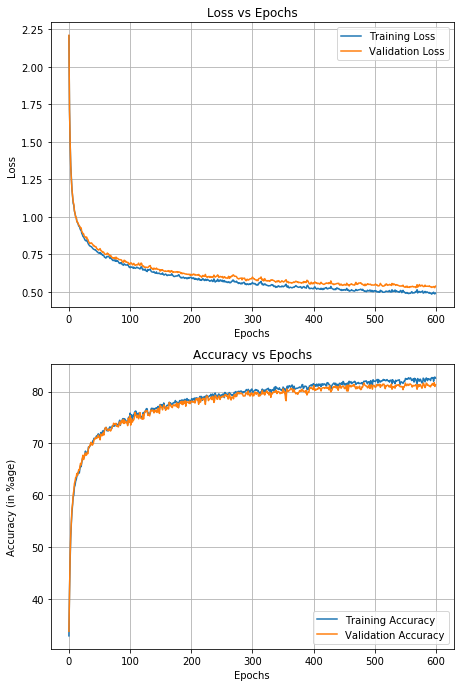

In [25]:
hist, w1, w2, w10, w20 = deep_learning(X_train, y_train, X_valid, y_valid, 5400, .0001, epochs=600, units = 40)

#### Evaluate the model on the test data

C:\Users\Utkarsh\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Task  1 : Accuracy of the model on the test set:  80.9 %
Task  1 : Confusion Matrix
[[778   5   8  29   0   3 179   0   4   0]
 [  5 933   4  18   2   1   1   0   0   0]
 [ 48  19 758  24 148   1 162   0  16   0]
 [ 77  33  16 831  38   0  68   0   8   1]
 [  8   4 141  54 715   0 120   0   4   0]
 [  3   0   1   1   0 879   1  38   7  15]
 [ 61   4  64  33  92   0 435   0  16   1]
 [  0   0   0   0   0  48   0 898   4  58]
 [ 20   2   8  10   5  12  34   0 939   1]
 [  0   0   0   0   0  56   0  64   2 924]]
Task  1 : Classification report
             precision    recall  f1-score   support

          0       0.78      0.77      0.78      1006
          1       0.93      0.97      0.95       964
          2       0.76      0.64      0.70      1176
          3       0.83      0.78      0.80      1072
          4       0.71      0.68      0.70      1046
          5       0.88      0.93      0.90       945
          6       0.43      0.62      0.51       706
          7       0.90      

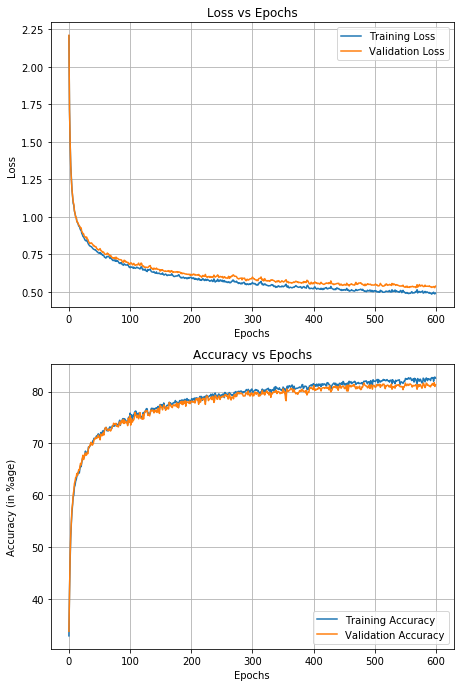

In [28]:
a2_test = predict_output(w1, w2, w10, w20, X_test)
a2_test.shape, y_test.shape

gen_full_report(1, a2_test, y_test, hist)

### Task 2: Build multi-layer Neural Network with open-source neural-network library, Keras
#### Design and compile our neural networking model

In [67]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

X_train, Y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, Y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

# making the model
model = Sequential()

# adding dense hidden layers and output layer
model.add(Dense(40, input_dim=784, activation='sigmoid'))
#model.add(Dense(40, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(10, activation='softmax'))

Y_train = transform_labels(Y_train, Y_train.shape[0]).T

# compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Train the model

Train on 54000 samples, validate on 6000 samples
Epoch 1/75
54000/54000 [==============================] - 1s 27us/step - loss: 2.0805 - accuracy: 0.2893 - val_loss: 1.8288 - val_accuracy: 0.4643
Epoch 2/75
54000/54000 [==============================] - 1s 22us/step - loss: 1.7027 - accuracy: 0.5556 - val_loss: 1.5463 - val_accuracy: 0.6348
Epoch 3/75
54000/54000 [==============================] - 1s 19us/step - loss: 1.4540 - accuracy: 0.6489 - val_loss: 1.3288 - val_accuracy: 0.6893
Epoch 4/75
54000/54000 [==============================] - 1s 19us/step - loss: 1.2498 - accuracy: 0.6948 - val_loss: 1.1428 - val_accuracy: 0.7228
Epoch 5/75
54000/54000 [==============================] - 1s 19us/step - loss: 1.0739 - accuracy: 0.7207 - val_loss: 0.9842 - val_accuracy: 0.7310
Epoch 6/75
54000/54000 [==============================] - 1s 19us/step - loss: 0.9299 - accuracy: 0.7478 - val_loss: 0.8548 - val_accuracy: 0.7682
Epoch 7/75
54000/54000 [==============================] - 1s 20us/ste

54000/54000 [==============================] - 1s 19us/step - loss: 0.3865 - accuracy: 0.8614 - val_loss: 0.4126 - val_accuracy: 0.8457
Epoch 57/75
54000/54000 [==============================] - 1s 18us/step - loss: 0.3855 - accuracy: 0.8595 - val_loss: 0.4093 - val_accuracy: 0.8508
Epoch 58/75
54000/54000 [==============================] - 1s 17us/step - loss: 0.3816 - accuracy: 0.8612 - val_loss: 0.4119 - val_accuracy: 0.8513
Epoch 59/75
54000/54000 [==============================] - 1s 14us/step - loss: 0.3835 - accuracy: 0.8624 - val_loss: 0.4247 - val_accuracy: 0.8468
Epoch 60/75
54000/54000 [==============================] - 1s 12us/step - loss: 0.3815 - accuracy: 0.8632 - val_loss: 0.4133 - val_accuracy: 0.8468
Epoch 61/75
54000/54000 [==============================] - 1s 13us/step - loss: 0.3842 - accuracy: 0.8612 - val_loss: 0.4164 - val_accuracy: 0.8462
Epoch 62/75
54000/54000 [==============================] - 1s 13us/step - loss: 0.3938 - accuracy: 0.8566 - val_loss: 0.4245

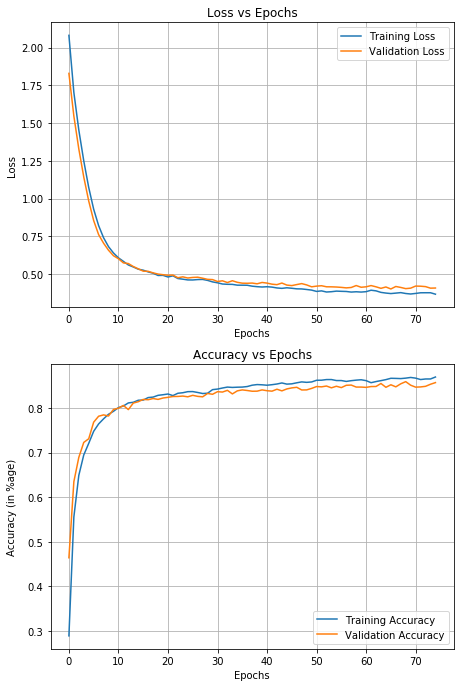

In [62]:
hist = model.fit(X_train, Y_train, epochs=75, batch_size=5400, validation_split=.1)
plot_graph(hist.history)

#### Evaluate the model on the test data

Task  2 : Accuracy of the model on the test set:  84.89 %
Task  2 : Confusion Matrix
[[828   6  16  34   1   0 136   0   3   0]
 [  3 959   2  18   2   1   3   0   1   0]
 [  8   6 649   7  56   0  74   0   6   0]
 [ 30  18  12 846  27   0  29   0   4   0]
 [  3   5 202  53 842   0 125   0   7   0]
 [  0   0   1   1   0 922   0  38   2  11]
 [110   3 106  39  65   0 612   0  16   0]
 [  0   0   0   0   0  39   0 917   4  31]
 [ 18   3  12   2   7   4  21   0 957   1]
 [  0   0   0   0   0  34   0  45   0 957]]
Task  2 : Classification report
             precision    recall  f1-score   support

          0       0.83      0.81      0.82      1024
          1       0.96      0.97      0.96       989
          2       0.65      0.81      0.72       806
          3       0.85      0.88      0.86       966
          4       0.84      0.68      0.75      1237
          5       0.92      0.95      0.93       975
          6       0.61      0.64      0.63       951
          7       0.92     

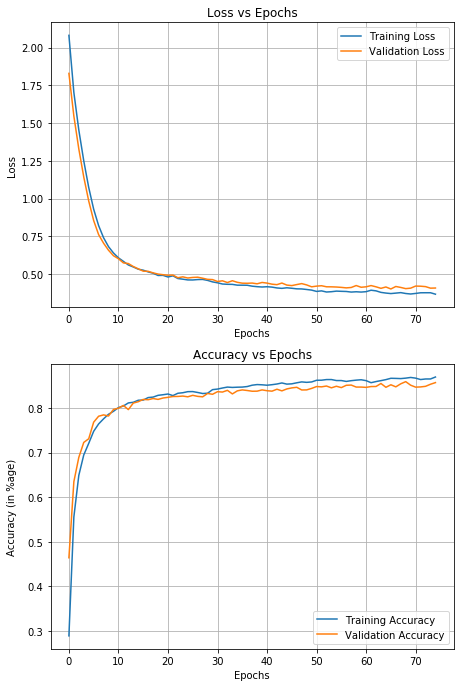

In [63]:
Y_predicted = model.predict(X_test)
Y_predicted = Y_predicted.T

gen_full_report(2, Y_predicted, Y_test, hist.history)

### Task 3: Train using Convolution Neural Network
#### Import libraries and preprocess images

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation, Flatten, Conv2D, MaxPooling2D 
import tensorflow as tf
from keras.utils import to_categorical
import util_mnist_reader as mnist_reader

# using modified data loading method from mnist_reader. # check util_mnist_reader.py file for code of function load_mnist_for_CNN()
x_train, y_train = mnist_reader.load_mnist_for_CNN('data/fashion', kind='train')
x_test, Y_test = mnist_reader.load_mnist_for_CNN('data/fashion', kind='t10k')

# preprocessing images data to use later
y_train = to_categorical(y_train)
print(x_train.shape[0:])
x_train = np.expand_dims(x_train, axis = 3)
x_test = np.expand_dims(x_test, axis = 3)

# this is required as model only accepts float values and not int for input
x_test = x_test.astype(float)
print(x_test.shape[0:])

(60000, 28, 28)
(10000, 28, 28, 1)


#### Design our convolutional neural network model

In [21]:
# adding convolution layers
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape = x_train.shape[1:]))
model.add(Activation("sigmoid"))
model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(64, (2,2)))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))

# flattening layer that transforms the image pixels to 1d array
model.add(Flatten())

# adding dense hidden layer and output layer
model.add(Dense(30, input_dim=784, activation='sigmoid'))
#model.add(Dense(40, activation='relu'))
#model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ['accuracy'])

#### Train the model

Train on 54000 samples, validate on 6000 samples
Epoch 1/85
54000/54000 [==============================] - 20s 372us/sample - loss: 2.2662 - accuracy: 0.2035 - val_loss: 2.0574 - val_accuracy: 0.4382
Epoch 2/85
54000/54000 [==============================] - 17s 314us/sample - loss: 1.9319 - accuracy: 0.4554 - val_loss: 1.8352 - val_accuracy: 0.4853
Epoch 3/85
54000/54000 [==============================] - 17s 315us/sample - loss: 1.7774 - accuracy: 0.5373 - val_loss: 1.7049 - val_accuracy: 0.5617
Epoch 4/85
54000/54000 [==============================] - 18s 338us/sample - loss: 1.6690 - accuracy: 0.5972 - val_loss: 1.6154 - val_accuracy: 0.6265
Epoch 5/85
54000/54000 [==============================] - 20s 368us/sample - loss: 1.5871 - accuracy: 0.6604 - val_loss: 1.5443 - val_accuracy: 0.7068
Epoch 6/85
54000/54000 [==============================] - 17s 319us/sample - loss: 1.5215 - accuracy: 0.7187 - val_loss: 1.4831 - val_accuracy: 0.7402
Epoch 7/85
54000/54000 [=====================

54000/54000 [==============================] - 18s 339us/sample - loss: 0.4208 - accuracy: 0.9047 - val_loss: 0.4368 - val_accuracy: 0.8993
Epoch 55/85
54000/54000 [==============================] - 19s 352us/sample - loss: 0.4140 - accuracy: 0.9057 - val_loss: 0.4313 - val_accuracy: 0.8987
Epoch 56/85
54000/54000 [==============================] - 20s 361us/sample - loss: 0.4077 - accuracy: 0.9076 - val_loss: 0.4256 - val_accuracy: 0.8990
Epoch 57/85
54000/54000 [==============================] - 17s 308us/sample - loss: 0.4017 - accuracy: 0.9078 - val_loss: 0.4215 - val_accuracy: 0.9003
Epoch 58/85
54000/54000 [==============================] - 21s 383us/sample - loss: 0.3959 - accuracy: 0.9086 - val_loss: 0.4161 - val_accuracy: 0.8995
Epoch 59/85
54000/54000 [==============================] - 18s 336us/sample - loss: 0.3911 - accuracy: 0.9104 - val_loss: 0.4103 - val_accuracy: 0.9017
Epoch 60/85
54000/54000 [==============================] - 18s 334us/sample - loss: 0.3869 - accurac

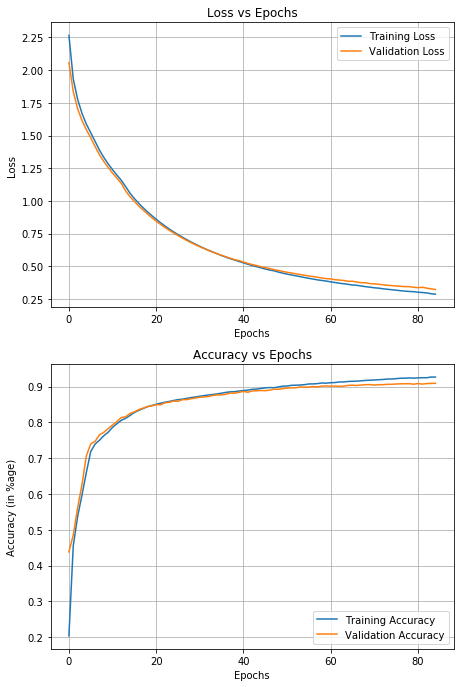

In [22]:
hist = model.fit(x_train, y_train, batch_size=5400, epochs=85, validation_split=.1)
plot_graph(hist.history)

#### Evaluate the model on the test data

Task  3 : Accuracy of the model on the test set:  90.38 %
Task  3 : Confusion Matrix
[[878   1  16  12   0   0 124   0   1   0]
 [  0 967   0   4   1   0   2   0   1   0]
 [ 17   1 887  12  67   0  77   0   2   0]
 [ 23  20   6 910  26   1  27   0   5   0]
 [  5   4  46  26 868   0  84   0   1   0]
 [  2   0   1   0   0 964   0  10   5   4]
 [ 65   6  43  35  37   0 667   0   7   0]
 [  0   0   0   0   0  23   0 965   4  37]
 [ 10   1   1   1   1   0  19   1 974   1]
 [  0   0   0   0   0  12   0  24   0 958]]
Task  3 : Classification report
             precision    recall  f1-score   support

          0       0.88      0.85      0.86      1032
          1       0.97      0.99      0.98       975
          2       0.89      0.83      0.86      1063
          3       0.91      0.89      0.90      1018
          4       0.87      0.84      0.85      1034
          5       0.96      0.98      0.97       986
          6       0.67      0.78      0.72       860
          7       0.96     

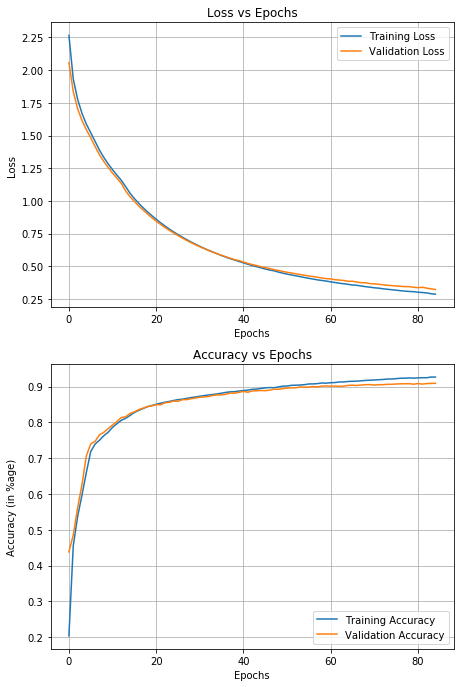

In [24]:
y_predicted = model.predict(x_test)
y_predicted = y_predicted.T

gen_full_report(3, y_predicted, y_test, hist.history)